In [1]:
#pip install -r http://webia.lip6.fr/~bpiwowar/requirements-amal.txt

In [2]:
# %load C:\Users\jacqu\Scolarite\M2A\AMAL\student_tp6\src\tp6-tagging.py
import itertools
import logging
from tqdm import tqdm

from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

from datamaestro import prepare_dataset
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
from typing import List
import time
logging.basicConfig(level=logging.INFO)

from torch.autograd import Variable
import numpy as np
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ds = prepare_dataset('org.universaldependencies.french.gsd')


# Format de sortie décrit dans
# https://pypi.org/project/conllu/

class Vocabulary:
    """Permet de gérer un vocabulaire.

    En test, il est possible qu'un mot ne soit pas dans le
    vocabulaire : dans ce cas le token "__OOV__" est utilisé.
    Attention : il faut tenir compte de cela lors de l'apprentissage !

    Utilisation:

    - en train, utiliser v.get("blah", adding=True) pour que le mot soit ajouté
      automatiquement
    - en test, utiliser v["blah"] pour récupérer l'ID du mot (ou l'ID de OOV)
    """
    OOVID = 1
    PAD = 0

    def __init__(self, oov: bool):
        self.oov =  oov
        self.id2word = [ "PAD"]
        self.word2id = { "PAD" : Vocabulary.PAD}
        if oov:
            self.word2id["__OOV__"] = Vocabulary.OOVID
            self.id2word.append("__OOV__")

    def __getitem__(self, word: str):
        if self.oov:
            return self.word2id.get(word, Vocabulary.OOVID)
        return self.word2id[word]

    def get(self, word: str, adding=True):
        try:
            return self.word2id[word]
        except KeyError:
            if adding:
                wordid = len(self.id2word)
                self.word2id[word] = wordid
                self.id2word.append(word)
                return wordid
            if self.oov:
                return Vocabulary.OOVID
            raise

    def __len__(self):
        return len(self.id2word)

    def getword(self,idx: int):
        if idx < len(self):
            return self.id2word[idx]
        return None

    def getwords(self,idx: List[int]):
        return [self.getword(i) for i in idx]



class TaggingDataset():
    def __init__(self, data, words: Vocabulary, tags: Vocabulary, adding=True):
        self.sentences = []

        for s in data:
            self.sentences.append(([words.get(token["form"], adding) for token in s], [tags.get(token["upostag"], adding) for token in s]))
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, ix):
        return self.sentences[ix]


def collate(batch):
    """Collate using pad_sequence"""
    return tuple(pad_sequence([torch.LongTensor(b[j]) for b in batch]) for j in range(2))
    


logging.info("Loading datasets...")
words = Vocabulary(True)
tags = Vocabulary(False)
train_data = TaggingDataset(ds.train, words, tags, True)
dev_data = TaggingDataset(ds.validation, words, tags, True)
test_data = TaggingDataset(ds.test, words, tags, False)


logging.info("Vocabulary size: %d", len(words))


BATCH_SIZE=100

train_loader = DataLoader(train_data, collate_fn=collate, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_data, collate_fn=collate, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, collate_fn=collate, batch_size=BATCH_SIZE)





INFO:root:Loading datasets...
INFO:root:Vocabulary size: 42930


In [3]:
def pad_collate(batch): #Je défini une fonction pad_collate, qui garde les longeurs pour pouvoir recoller plus tard.
    x_lens = [len(torch.LongTensor(b[0])) for b in batch]
    x_pad = pad_sequence([torch.LongTensor(b[0]) for b in batch])
    y_pad = pad_sequence([torch.LongTensor(b[1]) for b in batch])
    
    return(x_pad,y_pad,x_lens)
    
pckdtrain_loader = DataLoader(train_data,collate_fn = pad_collate,batch_size =BATCH_SIZE)
pckdtest_loader =  DataLoader(test_data,collate_fn = pad_collate,batch_size =BATCH_SIZE)

def eps_random(phrase,n_rd = 3): #Je prends maximum n_rd élements aléatoires par batch que je place hors du vocabulaire
    for k in range(n_rd):
        a,b = np.random.randint(phrase.size(0)),np.random.randint(phrase.size(1))
        if phrase[a][b] != torch.tensor(0):
            phrase[a][b] = torch.tensor(1)
    return phrase
    

# LSTM

In [4]:
class LSTM(nn.Module):  
    def __init__(self, dim_emb, dim_hidden, dim_out,n_layers):
        super(LSTM, self).__init__()
        
        self.dim_emb = dim_emb
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.n_layers = n_layers
        
        self.emb = torch.nn.Embedding(len(words),dim_emb)
        
        self.lstm = torch.nn.LSTM(dim_emb,dim_hidden,n_layers)
        self.decoder = nn.Linear(dim_hidden,dim_out)
        
    def forward(self, x, h, C):        
        z = self.emb(x) 
        output,(h_n,c_n) = self.lstm(z,(h,C))
        
        return(output,h_n,c_n)
    
    def decode(self,h):
        return(self.decoder(h))
    
    def init_hidden(self, batch_size):
        hidden = Variable(next(self.parameters()).data.new(self.n_layers, batch_size, self.dim_hidden))
        cell =  Variable(next(self.parameters()).data.new(self.n_layers, batch_size, self.dim_hidden))
        return (hidden, cell)
    
class pckdLSTM(nn.Module):  ## Etant donné que je fais mon embedding dans le réseau, je dois défnir une classe adaptée.
    def __init__(self, dim_emb, dim_hidden, dim_out,n_layers):
        super(pckdLSTM, self).__init__()
        
        self.dim_emb = dim_emb
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.n_layers = n_layers
        
        self.emb = torch.nn.Embedding(len(words),dim_emb)
        
        self.lstm = torch.nn.LSTM(dim_emb,dim_hidden,n_layers)
        self.decoder = nn.Linear(dim_hidden,dim_out)
        
    def forward(self, x, x_lens, h, C): #En effet,je dois "pack" ma sequence entre l'embedding et l'application du réseau      
        x_emb = self.emb(x)
        x_packed = pack_padded_sequence(x_emb,x_lens,enforce_sorted = False)
        
        output,(h_n,c_n) = self.lstm(x_packed,(h,C))
        
        return(output,h_n,c_n)
    
    def decode(self,h):
        return(self.decoder(h))
    
    def init_hidden(self, batch_size):
        hidden = Variable(next(self.parameters()).data.new(self.n_layers, batch_size, self.dim_hidden))
        cell =  Variable(next(self.parameters()).data.new(self.n_layers, batch_size, self.dim_hidden))
        return (hidden, cell)

# TRAIN

In [5]:
nbr_epoch = 45
batch_size = 100
dim_hidden = 110
dim_emb = 120
dim_out = len(tags)
n_layers = 5
eps = 1e-3
PAD = 0
criterion = nn.CrossEntropyLoss(ignore_index=PAD)
network = LSTM(dim_emb, dim_hidden, dim_out,n_layers).to(device)
optim = torch.optim.Adam(params = network.parameters(), lr = eps)

In [6]:
l = float('inf')
t =  0
list_loss_LSTM,epoch_loss_LSTM,Big_list_loss_LSTM = [],[],[]
start = time.time()
print("begin training")
for epoch in range(nbr_epoch):
    
    Big_list_loss_LSTM += list_loss_LSTM
    epoch_loss_LSTM.append(np.mean(list_loss_LSTM))
    list_loss_LSTM = []
    
    for batch_ndx, sample in enumerate(train_loader):

        if batch_ndx == 143:
            break        
        phrases,target_tag = sample
        phrases = phrases.to(device)
        target_tag = target_tag.to(device)
        
        optim.zero_grad()
        
        h_state,c_state = network.init_hidden(batch_size)
        output,new_h,new_c = network.forward(phrases,h_state,c_state)
        h = network.decode(output)
        l = criterion(h.view((-1,len(tags))),target_tag.flatten())
            
        list_loss_LSTM.append(float(l))
        l.backward()
        optim.step()
        
    print("epoch loss is",np.mean(list_loss_LSTM) )    

stop = time.time()
print(f"Done {nbr_epoch} epoch in {(stop-start)/60 :.2} minutes.")        

begin training


C:\Users\jacqu\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jacqu\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch loss is 2.4293168157964318
epoch loss is 1.5138093654092375
epoch loss is 0.8181695129487898
epoch loss is 0.5795937486878642
epoch loss is 0.44945026402706867
epoch loss is 0.36055748383482017
epoch loss is 0.29487476346792874
epoch loss is 0.24846834131887743
epoch loss is 0.2150629434760634
epoch loss is 0.18896028170218834
epoch loss is 0.16926902074080247
epoch loss is 0.1522412282395196
epoch loss is 0.1410315073245055
epoch loss is 0.12834911746578617
epoch loss is 0.11846521538454335
epoch loss is 0.11805807814731464
epoch loss is 0.10541823157272139
epoch loss is 0.10214560234046483
epoch loss is 0.09987329905266529
epoch loss is 0.0883662862169159
epoch loss is 0.0831603744698988
epoch loss is 0.0840302440305273
epoch loss is 0.07447263632308353
epoch loss is 0.07245316458019344
epoch loss is 0.06849516256080641
epoch loss is 0.06750122119079936
epoch loss is 0.07327670762901539
epoch loss is 0.061644677593783066
epoch loss is 0.057411526153971264
epoch loss is 0.057199

In [7]:
batch_size = 100
dim_hidden = 110
dim_emb = 120
dim_out = len(tags)
n_layers = 5
eps = 1e-3
PAD = 0
criterion2 = nn.CrossEntropyLoss(ignore_index=PAD)
network2 = pckdLSTM(dim_emb, dim_hidden, dim_out,n_layers).to(device)
optim2 = torch.optim.Adam(params = network2.parameters(), lr = eps)

In [8]:
l = float('inf')
t =  0
list_loss_LSTM2,epoch_loss_LSTM2,Big_list_loss_LSTM2 = [],[],[]
start = time.time()
print("begin training")
for epoch in range(nbr_epoch):
    
    Big_list_loss_LSTM2 += list_loss_LSTM2
    epoch_loss_LSTM2.append(np.mean(list_loss_LSTM2))
    list_loss_LSTM2 = []
    
    for batch_ndx, sample in enumerate(pckdtrain_loader):

        if batch_ndx == 143:
            break        
        phrases,target_tag,phrase_len = sample
        phrases = phrases.to(device)
        target_tag = target_tag.to(device)
        #phrase_len = phrase_len.to(device)
        
        optim2.zero_grad()
        
        h_state,c_state = network2.init_hidden(batch_size)
        output_packed,new_h,new_c = network2.forward(phrases,phrase_len,h_state,c_state)
        output,output_lengths = pad_packed_sequence(output_packed)
        h = network2.decode(output)
        l = criterion2(h.view((-1,len(tags))),target_tag.flatten())
            
        list_loss_LSTM2.append(float(l))
        l.backward()
        optim2.step()
        
    print("epoch loss is",np.mean(list_loss_LSTM2) )    
    

stop = time.time()
print(f"Done {nbr_epoch} epoch in {(stop-start)/60 :.2} minutes.")    
    

begin training
epoch loss is 2.426629521630027
epoch loss is 1.6132978542701348
epoch loss is 0.8952036987651478
epoch loss is 0.5984157313416888
epoch loss is 0.4545970529943079
epoch loss is 0.36704570784435403
epoch loss is 0.31047966096784685
epoch loss is 0.26604184716731516
epoch loss is 0.23051318682573893
epoch loss is 0.20289656478208262
epoch loss is 0.18149286446037827
epoch loss is 0.16894725720573972
epoch loss is 0.15767695629721754
epoch loss is 0.14522215046665884
epoch loss is 0.1331881036708405
epoch loss is 0.12552198137228304
epoch loss is 0.11755983552315852
epoch loss is 0.11205398317400392
epoch loss is 0.10926203299444039
epoch loss is 0.10469266438817644
epoch loss is 0.10033260978810438
epoch loss is 0.10073527292563365
epoch loss is 0.09718083777836153
epoch loss is 0.09846188742797692
epoch loss is 0.09553591320877308
epoch loss is 0.08456916721550735
epoch loss is 0.07649772869540261
epoch loss is 0.07252417788743139
epoch loss is 0.06970989391520306
epoch 

In [9]:
batch_size = 100
dim_hidden = 110
dim_emb = 120
dim_out = len(tags)
n_layers = 6
eps = 5e-4
PAD = 0
criterion3 = nn.CrossEntropyLoss(ignore_index=PAD)
network3 = pckdLSTM(dim_emb, dim_hidden, dim_out,n_layers).to(device)
optim3 = torch.optim.Adam(params = network3.parameters(), lr = eps)

In [10]:
l = float('inf')
t =  0
list_loss_LSTM3,epoch_loss_LSTM3,Big_list_loss_LSTM3 = [],[],[]
start = time.time()
print("begin training")
for epoch in range(nbr_epoch):
    
    Big_list_loss_LSTM3 += list_loss_LSTM3
    epoch_loss_LSTM3.append(np.mean(list_loss_LSTM3))
    list_loss_LSTM3 = []
    
    for batch_ndx, sample in enumerate(pckdtrain_loader):

        if batch_ndx == 143:
            break        
        phrases,target_tag,phrase_len = sample
        phrases_rd = eps_random(phrases)  """"Je randomise un ou deux élément des phrases"""
        phrases = phrases_rd.to(device)
        target_tag = target_tag.to(device)
        #phrase_len = phrase_len.to(device)
        
        optim3.zero_grad()
        
        h_state,c_state = network3.init_hidden(batch_size)
        output_packed,new_h,new_c = network3.forward(phrases,phrase_len,h_state,c_state)
        output,output_lengths = pad_packed_sequence(output_packed)
        h = network3.decode(output)
        l = criterion3(h.view((-1,len(tags))),target_tag.flatten())
            
        list_loss_LSTM3.append(float(l))
        l.backward()
        optim3.step()
        
    print("epoch loss is",np.mean(list_loss_LSTM3))    

stop = time.time()
print(f"Done {nbr_epoch} epoch in {(stop-start)/60 :.2} minutes.")    
  

begin training
epoch loss is 2.4707230587939284
epoch loss is 2.36259749719313
epoch loss is 2.1373294566894745
epoch loss is 1.2893585654405446
epoch loss is 0.8783888896028479
epoch loss is 0.6841358196485293
epoch loss is 0.5616360202535883
epoch loss is 0.4794025685820546
epoch loss is 0.416143317322631
epoch loss is 0.3699703018565278
epoch loss is 0.325891516216985
epoch loss is 0.29300022750467686
epoch loss is 0.27052881167485165
epoch loss is 0.25297793047828276
epoch loss is 0.2297815939971617
epoch loss is 0.21170861383418102
epoch loss is 0.19927892078469683
epoch loss is 0.18517055221787698
epoch loss is 0.17356570533939175
epoch loss is 0.16553610672692318
epoch loss is 0.1596308444867601
epoch loss is 0.1538809618124595
epoch loss is 0.15275356335031404
epoch loss is 0.1511603666769041
epoch loss is 0.14159567351941463
epoch loss is 0.13522665150515684
epoch loss is 0.13304988049960637
epoch loss is 0.1343920980091695
epoch loss is 0.13910254711037748
epoch loss is 0.139

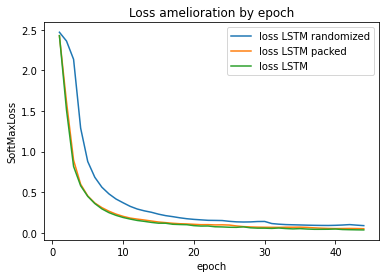

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.arange(len(epoch_loss_LSTM3)),epoch_loss_LSTM3,label = 'loss LSTM randomized')
ax.plot(np.arange(len(epoch_loss_LSTM2)),epoch_loss_LSTM2,label = 'loss LSTM packed')
ax.plot(np.arange(len(epoch_loss_LSTM)),epoch_loss_LSTM,label = 'loss LSTM')
ax.set_title("Loss amelioration by epoch")
ax.set_xlabel("epoch")
ax.set_ylabel("SoftMaxLoss")
ax.legend();

# TEST

In [12]:
##Un peu de Test:
test_loss = []
for batch_ndx, sample in enumerate(test_loader):

        if batch_ndx == 13:
            break        
        phrases,target_tag = sample
        phrases = phrases.to(device)
        target_tag = target_tag.to(device)
        
        optim.zero_grad()
        
        h_state,c_state = network.init_hidden(batch_size)
        output,new_h,new_c = network.forward(phrases,h_state,c_state)
        h = network.decode(output)
        l = criterion(h.view((-1,len(tags))),target_tag.flatten())
            
        test_loss.append(float(l))
          
print("test loss is",np.mean(test_loss))
pckdtest_loss = []
for batch_ndx, sample in enumerate(pckdtest_loader):

        if batch_ndx == 13:
            break        
        phrases,target_tag,phrase_len = sample
        phrases = phrases.to(device)
        target_tag = target_tag.to(device)
        #phrase_len = phrase_len.to(device)
        
        optim2.zero_grad()
        
        h_state,c_state = network2.init_hidden(batch_size)
        output_packed,new_h,new_c = network2.forward(phrases,phrase_len,h_state,c_state)
        output,output_lengths = pad_packed_sequence(output_packed)
        h = network2.decode(output)
        l = criterion2(h.view((-1,len(tags))),target_tag.flatten())
            
        pckdtest_loss.append(float(l))
                
print("pckd test loss is",np.mean(pckdtest_loss))

rd_test_loss = []
for batch_ndx, sample in enumerate(pckdtest_loader):

        if batch_ndx == 13:
            break        
        phrases,target_tag,phrase_len = sample
        phrases = phrases.to(device)
        target_tag = target_tag.to(device)
        #phrase_len = phrase_len.to(device)
        
        optim3.zero_grad()
        
        h_state,c_state = network3.init_hidden(batch_size)
        output_packed,new_h,new_c = network3.forward(phrases,phrase_len,h_state,c_state)
        output,output_lengths = pad_packed_sequence(output_packed)
        h = network3.decode(output)
        l = criterion3(h.view((-1,len(tags))),target_tag.flatten())
            
        rd_test_loss.append(float(l))
        
        
print("randomized test loss is",np.mean(rd_test_loss))



L = torch.tensor([torch.argmax(k) for k in h[:,0]])
print('prévisions:',L,L.shape)
print('vs')
print('réalité:',target_tag[:,0],target_tag[:,0].shape)
print('le padding ignore les 0 au bout de séquence !')
  

test loss is 0.7632154776499822
pckd test loss is 0.9133736261954675
randomized test loss is 1.1438544300886302
prévisions: tensor([11, 12, 16,  1,  2,  7,  3, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7]) torch.Size([86])
vs
réalité: tensor([ 1,  2,  5,  1,  2,  7,  2, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       device='cuda:0') torch.Size([86])
le padding ignore les 0 au bout de s

### Bilan:
les courbes d'apprentissage ont exactement la tête attendue, mais le "randomized" a les moins bons résultats en test, alors qu'il devrait avoir les meilleurs, car il sait a priori gérer des mots inconnus.